In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# depend on tensorflow 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels

# Set number of GPUs

In [2]:
import os
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
# print out local devices visible to TensorFlow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9969152893093481404, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13306140185482249891
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 66717527935459832
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15651402548
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4754660128153865496
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0"]

# Data

## load genotype

In [4]:
# get genotype col names
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
with open(vcf_file, 'r') as f_vcf:
    while True:
        line = f_vcf.readline()
        if line[:2]!='##':
            break

    col_names = line[1:].split()
        
# print(col_names)

In [5]:
# load genotype
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
vcf_genotype = pd.read_csv(
    vcf_file,
    sep='\t',
    header=None,
    names=col_names,
    comment='#')

vcf_genotype

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,0/1,...,0/1,1/1,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0/0,...,0/1,0/0,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,0/1,...,0/1,0/1,0/0,0/1,0/1,0/1,0/1,1/1,0/1,0/1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,0/1,...,0/1,0/0,0/0,0/0,0/1,0/1,0/1,0/0,0/0,0/0


In [6]:
# replace genotype with integers
vcf_int = vcf_genotype.replace({
    './.': np.NaN,
    '0/0': 0,
    '0/1': 1,
    '1/0': 1,
    '1/1': 2
})

vcf_int

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,1,...,1,2,1,0,1,1,1,1,1,0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,1,...,1,1,0,1,1,1,1,2,1,1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,1,...,1,0,0,0,1,1,1,0,0,0


In [7]:
# snp matrix with shape of (SNP loci, individual)
snp_ind_matrix = vcf_int.iloc[:, 9:]
snp_ind_matrix

,2_123_S_0108,2_024_S_0985,2_131_S_0123,2_098_S_0160,2_027_S_0256,2_116_S_1243,2_073_S_2264,2_094_S_2216,2_021_S_0337,2_141_S_1255,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
1,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
2,1,0,1,2,0,0,1,0,1,1,...,1,2,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,2,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1,2,1,0,0,2,1,2,1,1,...,1,1,0,1,1,1,1,2,1,1
1779,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1780,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1781,1,0,1,2,1,0,1,0,1,0,...,1,0,0,0,1,1,1,0,0,0


In [8]:
# transposition is necessary.
ind_snp_matrix = snp_ind_matrix.transpose()
ind_snp_matrix

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_123_S_0108,0,0,1,0,0,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_0985,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
2_131_S_0123,1,1,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_098_S_0160,2,2,2,0,0,2,2,0,0,2,...,2,2,2,2,2,0,0,0,2,0
2_027_S_0256,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_002_S_4264,1,1,1,0,1,1,1,0,0,1,...,0,0,0,1,1,1,0,0,1,1
2_021_S_2077,0,0,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_4186,0,0,1,0,1,1,0,1,1,0,...,0,0,0,0,0,2,0,0,0,2
2_128_S_2057,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,1,1,0,1


## load phenotype

In [9]:
# load phenotype
ADAS_file = 'data/ADAS_selected.csv'
ADAS_data = pd.read_csv(ADAS_file, sep=',', header=0)
ADAS_data = ADAS_data.dropna()
ADAS_data

,RID,TOTSCORE,TOTAL13
0,31,5.0,10.0
1,35,6.0,13.0
2,47,8.0,14.0
3,51,9.0,20.0
4,58,5.0,10.0
...,...,...,...
930,5283,3.0,7.0
931,5287,3.0,4.0
932,5288,6.0,8.0
933,5290,5.0,6.0


In [10]:
ADAS_data[['TOTSCORE','TOTAL13']].describe()

,TOTSCORE,TOTAL13
count,930.000000,930.000000
mean,10.259140,16.009677
std,7.352463,10.353541
min,0.000000,0.000000
25%,5.000000,9.000000
50%,8.000000,13.000000
75%,13.000000,21.000000
max,52.000000,67.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcc8786898>,
      dtype=object)

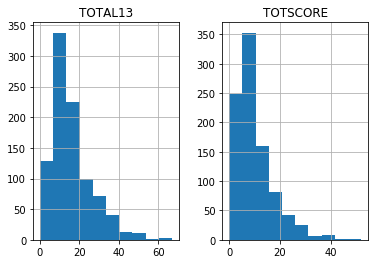

In [11]:
ADAS_data[['TOTSCORE','TOTAL13']].hist()

In [12]:
# from sklearn.preprocessing import normalize
Y = np.asarray(ADAS_data['TOTSCORE'])

In [13]:
# normlization
Y = (Y - Y.min()) / (Y.max() - Y.min())

## Intersection

In [14]:
genetic_id = [x[-4:] for x in ind_snp_matrix.index]
rid = ['{:04d}'.format(x) for x in ADAS_data['RID']]

In [15]:
row_id = [genetic_id.index(x) for x in rid]

In [16]:
X = ind_snp_matrix.iloc[row_id, :]
X

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_023_S_0031,1,1,1,0,1,1,1,0,0,1,...,2,2,2,2,2,0,0,0,2,0
2_100_S_0035,0,0,1,0,1,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_100_S_0047,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
2_099_S_0051,2,2,2,1,0,2,2,0,0,2,...,0,1,1,1,1,1,0,0,1,1
2_023_S_0058,0,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_036_S_5283,2,2,2,1,0,2,2,0,0,2,...,1,2,2,2,2,0,0,0,2,0
2_053_S_5287,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
2_027_S_5288,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_5290,1,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,0,0,1,1


## Onehot encode

In [17]:
## One-hot encoding
X_onehot = to_categorical(X)
X_onehot.shape

(930, 1783, 3)

In [18]:
# padding 1 for autoencoder 
X_onehot_padding=np.pad(X_onehot,[[0,0],[0,1],[0,0]])
X_onehot_padding.shape

(930, 1784, 3)

## Split train and test

In [19]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot_padding, Y, test_size=0.2)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((744, 1784, 3), (186, 1784, 3), (744,), (186,))

In [20]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.2)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((595, 1784, 3), (149, 1784, 3), (595,), (149,))

# Method 

## Autoencoder

In [21]:
# hyperparameters
batch_size = 16
lr = 0.001
epochs = 1000

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = 3
kr = 1e-4
drop_prec = 0.5

In [22]:
autoencoder = Sequential()
# encoder
# tall and thin
autoencoder.add(
    Conv1D(num_kernels,
           5,
           padding='same',
           activation='relu',
           kernel_regularizer=l1(kr),
           input_shape=(feature_size, inChannel)))
# autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(drop_prec))
autoencoder.add(AveragePooling1D(pool_size=2))

autoencoder.add(Flatten())

autoencoder.add(Dense(int(feature_size), activation='relu'))
autoencoder.add(Dropout(drop_prec))
autoencoder.add(BatchNormalization())
autoencoder.add(Dense(int(feature_size * num_kernels / 2), activation='relu'))
autoencoder.add(Dropout(drop_prec))
# autoencoder.add(BatchNormalization())
autoencoder.add(Reshape((int(feature_size / 2), num_kernels)))

# decoder
autoencoder.add(
    Conv1D(num_kernels,
           5,
           padding='same',
           activation='relu',
           kernel_regularizer=l1(kr)))
# autoencoder.add(BatchNormalization())
autoencoder.add(Dropout(drop_prec))
autoencoder.add(UpSampling1D(2))

autoencoder.add(
    Conv1D(inChannel,
           5,
           activation='sigmoid',
           padding='same',
           kernel_regularizer=l1(kr)))

# compile
autoencoder.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
# summary
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1784, 16)          256       
_________________________________________________________________
dropout (Dropout)            (None, 1784, 16)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 892, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14272)             0         
_________________________________________________________________
dense (Dense)                (None, 1784)              25463032  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1784)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1784)              7

In [23]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/ADAS_autoencoder_checkpoint.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

In [24]:
autoencoder_log = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_valid, X_valid),
    callbacks=[EarlyStopping]
)

Train on 595 samples, validate on 149 samples
Epoch 1/1000
595/595 - 7s - loss: 0.6419 - accuracy: 0.6454 - val_loss: 0.5880 - val_accuracy: 0.6842
Epoch 2/1000
595/595 - 1s - loss: 0.5857 - accuracy: 0.6817 - val_loss: 0.5854 - val_accuracy: 0.7079
Epoch 3/1000
595/595 - 1s - loss: 0.5689 - accuracy: 0.6976 - val_loss: 0.5456 - val_accuracy: 0.7144
Epoch 4/1000
595/595 - 1s - loss: 0.5563 - accuracy: 0.7077 - val_loss: 0.5449 - val_accuracy: 0.7159
Epoch 5/1000
595/595 - 1s - loss: 0.5470 - accuracy: 0.7143 - val_loss: 0.5359 - val_accuracy: 0.7251
Epoch 6/1000
595/595 - 1s - loss: 0.5377 - accuracy: 0.7217 - val_loss: 0.5289 - val_accuracy: 0.7295
Epoch 7/1000
595/595 - 1s - loss: 0.5304 - accuracy: 0.7273 - val_loss: 0.5202 - val_accuracy: 0.7372
Epoch 8/1000
595/595 - 1s - loss: 0.5241 - accuracy: 0.7327 - val_loss: 0.5155 - val_accuracy: 0.7413
Epoch 9/1000
595/595 - 1s - loss: 0.5184 - accuracy: 0.7370 - val_loss: 0.5088 - val_accuracy: 0.7449
Epoch 10/1000
595/595 - 1s - loss: 0

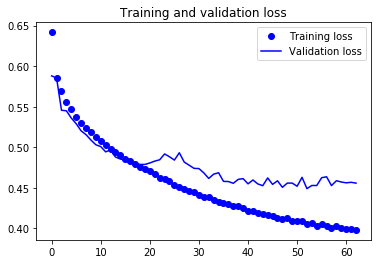

In [25]:
# plot loss curve on validation data
loss = autoencoder_log.history['loss']
val_loss = autoencoder_log.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('ADAS_autoencoder_loss_curve.png')

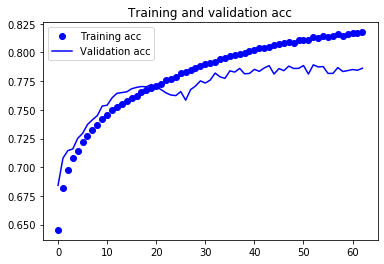

In [26]:
# plot accuracy curve on validation data
acc = autoencoder_log.history['accuracy']
val_acc = autoencoder_log.history['val_accuracy']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.savefig('ADAS_autoencoder_acc_curve.png')

## Predictor

In [27]:
# hyperparameters
epochs = 50

In [28]:
# # Build predicition model
predictor = Sequential()

for i in range(8):
    # make encoder layers in autoencoder non-trainable
    autoencoder.layers[i].trainable = False
    predictor.add(autoencoder.layers[i])

predictor.add(
    Dense(int(feature_size/2), activation='relu'))
# predictor.add(Dropout(drop_prec))
predictor.add(BatchNormalization())
predictor.add(Dense(1))

# compile
predictor.compile(loss='mse', optimizer='adam', metrics=['mse'])

# summary
predictor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1784, 16)          256       
_________________________________________________________________
dropout (Dropout)            (None, 1784, 16)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 892, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14272)             0         
_________________________________________________________________
dense (Dense)                (None, 1784)              25463032  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1784)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1784)             

## Training

In [29]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/untrainable_predictor_checkpoint.h5',
    monitor='val_mse',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

In [30]:
predictor_log = predictor.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping]
)

Train on 595 samples, validate on 149 samples
Epoch 1/50
595/595 [==============================] - 1s 2ms/sample - loss: 15.0903 - mse: 15.0900 - val_loss: 1.3117 - val_mse: 1.3114
Epoch 2/50
595/595 [==============================] - 0s 803us/sample - loss: 1.5188 - mse: 1.5185 - val_loss: 0.3457 - val_mse: 0.3454
Epoch 3/50
595/595 [==============================] - 0s 797us/sample - loss: 0.3750 - mse: 0.3747 - val_loss: 0.2054 - val_mse: 0.2050
Epoch 4/50
595/595 [==============================] - 0s 791us/sample - loss: 0.1986 - mse: 0.1982 - val_loss: 0.0535 - val_mse: 0.0531
Epoch 5/50
595/595 [==============================] - 0s 335us/sample - loss: 0.1520 - mse: 0.1517 - val_loss: 0.0620 - val_mse: 0.0616
Epoch 6/50
595/595 [==============================] - 0s 326us/sample - loss: 0.0994 - mse: 0.0991 - val_loss: 0.0679 - val_mse: 0.0676
Epoch 7/50
595/595 [==============================] - 0s 822us/sample - loss: 0.0820 - mse: 0.0817 - val_loss: 0.0300 - val_mse: 0.0297
Ep

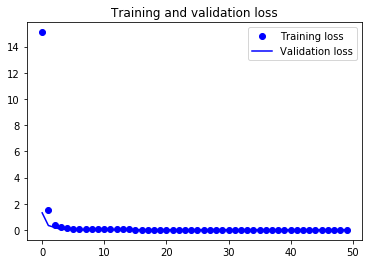

In [31]:
# plot loss curve on validation data
loss = predictor_log.history['loss']
val_loss = predictor_log.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

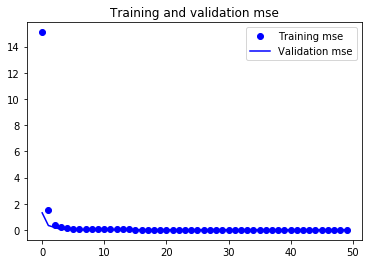

In [32]:
# plot accuracy curve on validation data
mse = predictor_log.history['mse']
val_mse = predictor_log.history['val_mse']
plt.figure()
plt.plot(range(len(mse)), mse, 'bo', label='Training mse')
plt.plot(range(len(val_mse)), val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.show()

## fine tune

In [33]:
# hyperparameters
epochs = 100

In [34]:
for layer in predictor.layers:
    # make encoder layers in autoencoder non-trainable
    layer.trainable = True

predictor.compile(loss='mse', optimizer='adam', metrics=['mse'])

predictor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1784, 16)          256       
_________________________________________________________________
dropout (Dropout)            (None, 1784, 16)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 892, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14272)             0         
_________________________________________________________________
dense (Dense)                (None, 1784)              25463032  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1784)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1784)             

In [35]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/fine_tune_predictor_checkpoint.h5',
    monitor='val_mse',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

In [36]:
fine_tune_predictor_log = predictor.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping])

Train on 595 samples, validate on 149 samples
Epoch 1/100
595/595 [==============================] - 2s 3ms/sample - loss: 0.1489 - mse: 0.1485 - val_loss: 0.0861 - val_mse: 0.0858
Epoch 2/100
595/595 [==============================] - 0s 586us/sample - loss: 0.0367 - mse: 0.0363 - val_loss: 0.1383 - val_mse: 0.1380
Epoch 3/100
595/595 [==============================] - 1s 1ms/sample - loss: 0.0237 - mse: 0.0233 - val_loss: 0.0182 - val_mse: 0.0178
Epoch 4/100
595/595 [==============================] - 0s 605us/sample - loss: 0.0179 - mse: 0.0175 - val_loss: 0.0196 - val_mse: 0.0193
Epoch 5/100
595/595 [==============================] - 0s 597us/sample - loss: 0.0169 - mse: 0.0165 - val_loss: 0.0187 - val_mse: 0.0184
Epoch 6/100
595/595 [==============================] - 1s 1ms/sample - loss: 0.0183 - mse: 0.0179 - val_loss: 0.0159 - val_mse: 0.0156
Epoch 7/100
595/595 [==============================] - 0s 607us/sample - loss: 0.0149 - mse: 0.0145 - val_loss: 0.0175 - val_mse: 0.0171
E

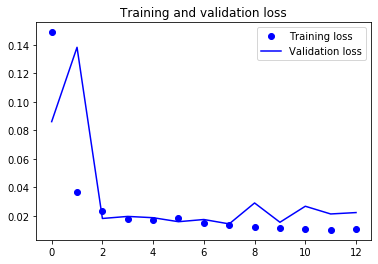

In [37]:
# plot loss curve on validation data
loss = fine_tune_predictor_log.history['loss']
val_loss = fine_tune_predictor_log.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

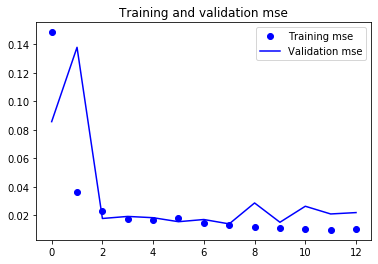

In [38]:
# plot accuracy curve on validation data
mse = fine_tune_predictor_log.history['mse']
val_mse = fine_tune_predictor_log.history['val_mse']
plt.figure()
plt.plot(range(len(mse)), mse, 'bo', label='Training mse')
plt.plot(range(len(val_mse)), val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.show()

# Prediction

In [39]:
# predict
Y_predict = predictor.predict(X_test)

In [40]:
len(Y_test)

186

In [41]:
# r_square
r2_score(Y_test,Y_predict[:,0])

-0.08061396823669043

In [42]:
mean_squared_error(Y_test,Y_predict[:,0])

0.024481499870705834

# Plot

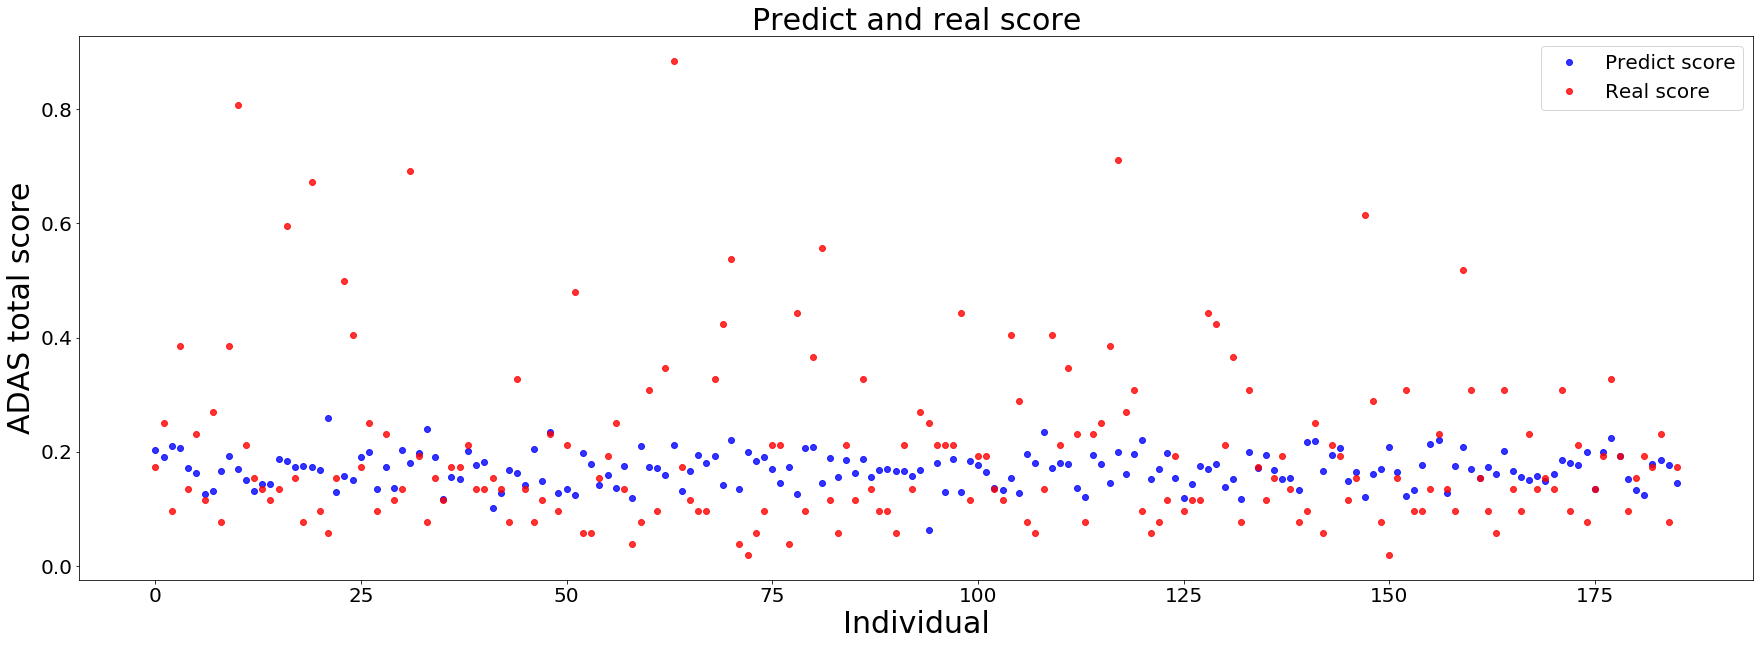

In [43]:
plt.figure(figsize=(30,10))
plt.plot(range(len(Y_test)), Y_predict, 'bo', alpha=0.8,label='Predict score')
plt.plot(range(len(Y_test)), Y_test, 'ro', alpha=0.8,label='Real score')
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

plt.title('Predict and real score',fontsize=30)
plt.xlabel('Individual', fontsize=30)
plt.ylabel('ADAS total score', fontsize=30)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbac1b45c0>]],
      dtype=object)

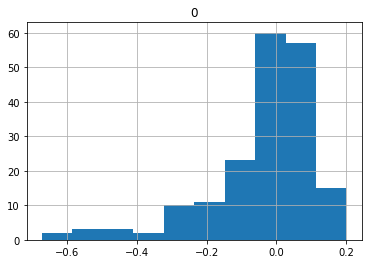

In [44]:
# difference histgram
diff=(Y_predict[:,0]-Y_test)
pd.DataFrame(diff).hist()